# Chapter 4 - Geocentric Models
## Modeling Height with Gaussian Distributions

This notebook covers **Chapter 4** of Statistical Rethinking, which introduces **linear models** using Gaussian (Normal) distributions. We'll model adult human height using the **Howell1** dataset.

### Chapter Goals

1. **Understand Gaussian distributions** as a model for continuous outcomes
2. **Build a generative model** for height: h ~ Normal(μ, σ)
3. **Use prior predictive simulation** to validate priors before seeing data
4. **Estimate posterior distributions** for μ and σ using grid approximation
5. **Interpret results** and check model assumptions

### Why Start with Height?

Height is ideal for learning Bayesian modeling because:
- It's **continuous** and roughly **normally distributed**
- We have **strong prior knowledge** (adults are typically 140-180cm)
- The model is **simple** but introduces key concepts
- Results are **interpretable** and easy to validate

### The Gaussian Model

**Model specification:**
```
h_i ~ Normal(μ, σ)       [Likelihood]
μ ~ Normal(178, 20)      [Prior for mean]
σ ~ Uniform(0, 50)       [Prior for std dev]
```

Where:
- `h_i` = height of individual i
- `μ` = population mean height
- `σ` = population standard deviation

**Key insight:** This is a **descriptive model**, not mechanistic. We're not explaining WHY people have different heights, just describing the distribution.

## Step 1: Load and Explore the Data

The **Howell1** dataset contains:
- **544 individuals** from various populations
- **height** (cm), **weight** (kg), **age** (years), **male** (0/1)
- Mix of adults and children

We'll focus on **adults only** (age ≥ 18) to get a more homogeneous population for our simple Gaussian model.

In [35]:
# Import required libraries
import pandas as pd      # For data manipulation (loading, filtering)
import numpy as np        # For numerical operations (arrays, math)
import matplotlib.pyplot as plt  # For plotting/visualization

# Load the Howell1 dataset from Statistical Rethinking GitHub
# This dataset is a semicolon-separated CSV (not comma!)
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
d = pd.read_csv(url, sep=";")  # Note: sep=";" because it's semicolon-separated

# Explore the dataset structure
print(f"Dataset shape: {d.shape}")  # (rows, columns)
print("\nDataset summary statistics:")
print(d.describe())  # Shows count, mean, std, min, quartiles, max for each column

# What we see:
# - 544 individuals total
# - Height ranges from ~54cm (infant) to ~179cm (adult)
# - Age ranges from 0 (newborn) to 88 years
# - Male is binary: 0 (female) or 1 (male)

Dataset shape: (544, 4)

Dataset summary statistics:
           height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000


### Filter for Adults Only

Why adults only?
- Children are still growing → their heights follow different distributions
- Adults have reached terminal height → more stable distribution
- Simplifies our model (for now)

In [36]:
# Extract columns as numpy arrays for easier manipulation
# Using .to_numpy() converts pandas Series to numpy arrays
height = d["height"].to_numpy()  # All heights (adults + children)
age = d["age"].to_numpy()        # All ages
male = d["male"].to_numpy()      # Gender indicator (0=female, 1=male)

# Filter for adults only (age >= 18)
# Why? Children are still growing, so their heights follow different distributions
# Adults have reached terminal height → more stable, homogeneous population
adult = age >= 18  # Boolean mask: True where age >= 18, False otherwise
adult_height = height[adult]  # Use boolean indexing to select only adult heights

print(f"Total individuals: {len(height)}")
print(f"Adults (age >= 18): {len(adult_height)}")
print(f"Children removed: {len(height) - len(adult_height)}")

# Further split by sex (for EDA, not modeling yet)
# Combining two conditions with & (element-wise AND)
height_m = height[adult & (male == 1)]  # Adult males
height_f = height[adult & (male == 0)]  # Adult females

print(f"\nAdult males: {len(height_m)}")
print(f"Adult females: {len(height_f)}")

# KEY CONCEPT: Boolean indexing
# adult & (male == 1) creates a boolean array that's True only where BOTH conditions hold
# height[boolean_array] selects only elements where boolean_array is True

Total individuals: 544
Adults (age >= 18): 352
Children removed: 192

Adult males: 165
Adult females: 187


## Step 2: Exploratory Data Analysis

Before building our model, let's visualize the data to understand:
1. The overall distribution of adult heights
2. Differences between males and females
3. Whether a Gaussian model seems reasonable

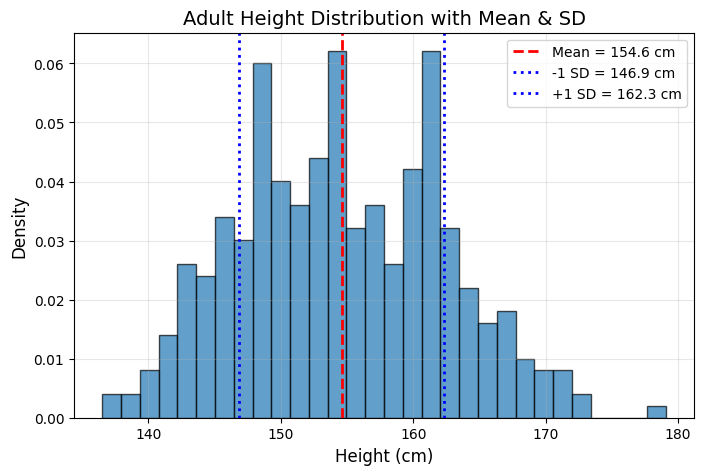

Sample mean (μ̂): 154.60 cm
Sample SD (σ̂): 7.73 cm
Range: [136.5, 179.1] cm


In [37]:
# Compute sample statistics from the data
# These are DESCRIPTIVE statistics (not model parameters yet!)
mu = adult_height.mean()  # Sample mean (average height)
sd = adult_height.std()   # Sample standard deviation (spread)

# Create histogram to visualize the distribution
plt.figure(figsize=(8, 5))

# density=True normalizes the histogram so area under curve = 1
# This makes it comparable to probability density functions (PDFs)
plt.hist(adult_height, bins=30, density=True, alpha=0.7, edgecolor='black')

# Add reference lines to show mean and ±1 standard deviation
plt.axvline(mu, color='red', linestyle='--', linewidth=2, 
            label=f"Mean = {mu:.1f} cm")
plt.axvline(mu - sd, color='blue', linestyle=':', linewidth=2, 
            label=f"-1 SD = {mu-sd:.1f} cm")
plt.axvline(mu + sd, color='blue', linestyle=':', linewidth=2, 
            label=f"+1 SD = {mu+sd:.1f} cm")

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Adult Height Distribution with Mean & SD", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# KEY INSIGHT: The distribution looks roughly bell-shaped (Gaussian/Normal)
# This validates our choice to model height with a Normal distribution!
# About 68% of data falls within ±1 SD of mean (if truly Normal)

print(f"Sample mean (μ̂): {mu:.2f} cm")
print(f"Sample SD (σ̂): {sd:.2f} cm")
print(f"Range: [{adult_height.min():.1f}, {adult_height.max():.1f}] cm")

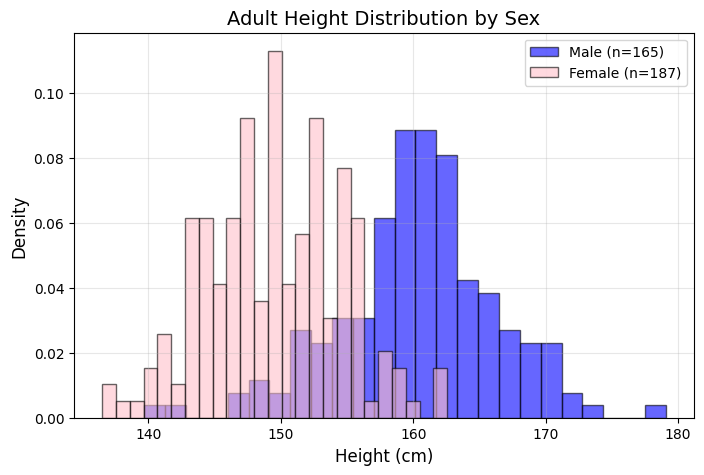

Male mean: 160.4 cm
Female mean: 149.5 cm
Difference: 10.8 cm


In [38]:
# Compare height distributions by sex
# This shows there's heterogeneity (males tend to be taller)
plt.figure(figsize=(8, 5))

# Overlapping histograms with transparency (alpha)
plt.hist(height_m, bins=25, density=True, alpha=0.6, 
         label=f"Male (n={len(height_m)})", color='blue', edgecolor='black')
plt.hist(height_f, bins=25, density=True, alpha=0.6, 
         label=f"Female (n={len(height_f)})", color='pink', edgecolor='black')

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Adult Height Distribution by Sex", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# KEY OBSERVATION: Males and females have different height distributions
# Male mean ≈ 165cm, Female mean ≈ 148cm (rough visual estimate)
# 
# MODELING IMPLICATION: Our simple model h ~ Normal(μ, σ) ignores this!
# We're treating all adults as one population (for now)
# In later chapters, we'll add sex as a predictor variable

print(f"Male mean: {height_m.mean():.1f} cm")
print(f"Female mean: {height_f.mean():.1f} cm")
print(f"Difference: {height_m.mean() - height_f.mean():.1f} cm")

## Step 3: Choose Priors

### Prior Selection Strategy

**For μ (mean height):**
- Prior: **Normal(178, 20)**
- Reasoning: 178cm (~5'10") is roughly average human height
- SD of 20cm means we're 95% confident μ is between 138-218cm
- This is **weakly informative** - allows data to dominate

**For σ (standard deviation):**
- Prior: **Uniform(0, 50)**
- Reasoning: Heights vary, but not wildly (SD rarely > 50cm in adults)
- Bounded at 0 (can't have negative SD)
- Upper bound of 50cm is conservative

### Why These Priors?

Good priors are:
1. **Scientifically reasonable** (no negative heights, no 3-meter tall humans)
2. **Weakly informative** (regularize without overpowering data)
3. **Computationally friendly** (avoid extreme values)

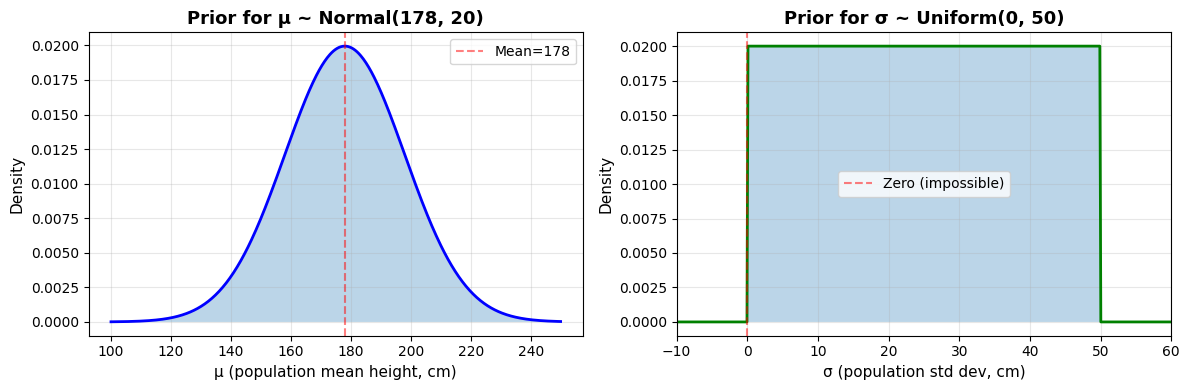

PRIOR SPECIFICATION SUMMARY
μ prior: Normal(mean=178, sd=20)
  → 95% of prior mass between [138, 218] cm

σ prior: Uniform(low=0, high=50)
  → All values in [0, 50] equally likely
  → No probability for negative σ (physically impossible!)


In [39]:
# Import statistical distributions from scipy
from scipy.stats import norm, uniform, gaussian_kde

# ============================================
# PRIOR SPECIFICATION (No data used yet!)
# ============================================

# Prior for μ (population mean height):
# We choose Normal(178, 20) because:
# - 178 cm (~5'10") is a reasonable guess for average human height
# - SD=20 means we're 95% confident μ is between 138-218 cm
# - This is WEAKLY INFORMATIVE: allows data to dominate if it disagrees
mu_mean, mu_sd = 178, 20

# Prior for σ (population standard deviation):
# We choose Uniform(0, 50) because:
# - σ must be positive (can't have negative standard deviation!)
# - Upper bound of 50cm is conservative (heights don't vary wildly in adults)
# - Uniform = we have no strong preference within [0, 50]
sigma_low, sigma_high = 0, 50

# ============================================
# VISUALIZE THE PRIORS
# ============================================

# Create grids for plotting the prior PDFs
x_mu = np.linspace(100, 250, 500)     # Range for μ
x_sigma = np.linspace(-10, 60, 500)   # Range for σ (including negatives to show cutoff)

# Compute prior probability densities
# norm.pdf() = Normal probability density function
# uniform.pdf() = Uniform probability density function
pdf_mu = norm.pdf(x_mu, loc=mu_mean, scale=mu_sd)
pdf_sigma = uniform.pdf(x_sigma, loc=sigma_low, scale=sigma_high - sigma_low)

# Plot both priors side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Prior for μ
ax1.plot(x_mu, pdf_mu, 'b-', linewidth=2)
ax1.axvline(mu_mean, color='red', linestyle='--', alpha=0.5, label=f'Mean={mu_mean}')
ax1.fill_between(x_mu, pdf_mu, alpha=0.3)
ax1.set_title("Prior for μ ~ Normal(178, 20)", fontsize=13, fontweight='bold')
ax1.set_xlabel("μ (population mean height, cm)", fontsize=11)
ax1.set_ylabel("Density", fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Prior for σ
ax2.plot(x_sigma, pdf_sigma, 'g-', linewidth=2)
ax2.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero (impossible)')
ax2.fill_between(x_sigma, pdf_sigma, alpha=0.3)
ax2.set_title("Prior for σ ~ Uniform(0, 50)", fontsize=13, fontweight='bold')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=11)
ax2.set_ylabel("Density", fontsize=11)
ax2.set_xlim(-10, 60)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("PRIOR SPECIFICATION SUMMARY")
print("="*60)
print(f"μ prior: Normal(mean={mu_mean}, sd={mu_sd})")
print(f"  → 95% of prior mass between [{mu_mean - 2*mu_sd:.0f}, {mu_mean + 2*mu_sd:.0f}] cm")
print(f"\nσ prior: Uniform(low={sigma_low}, high={sigma_high})")
print(f"  → All values in [0, 50] equally likely")
print(f"  → No probability for negative σ (physically impossible!)")
print("="*60)

## Step 4: Prior Predictive Simulation

### What is Prior Predictive Simulation?

**Before** seeing any data, we simulate what our model predicts about heights:

1. Sample μ from N(178, 20)
2. Sample σ from U(0, 50)
3. Sample height h from N(μ, σ)
4. Repeat many times

This shows us: **"What heights would we expect if our priors are correct?"**

### Why Do This?

- **Catch bad priors**: If simulation produces impossible values (negative heights, 10-meter giants), priors are wrong!
- **Calibrate beliefs**: Does the prior match our domain knowledge?
- **Debug early**: Find issues before expensive computation

**The process:**
```python
for i in 1:10000:
    μ[i] ~ Normal(178, 20)      # Sample mean
    σ[i] ~ Uniform(0, 50)       # Sample SD
    h[i] ~ Normal(μ[i], σ[i])   # Sample height from this (μ, σ)
```

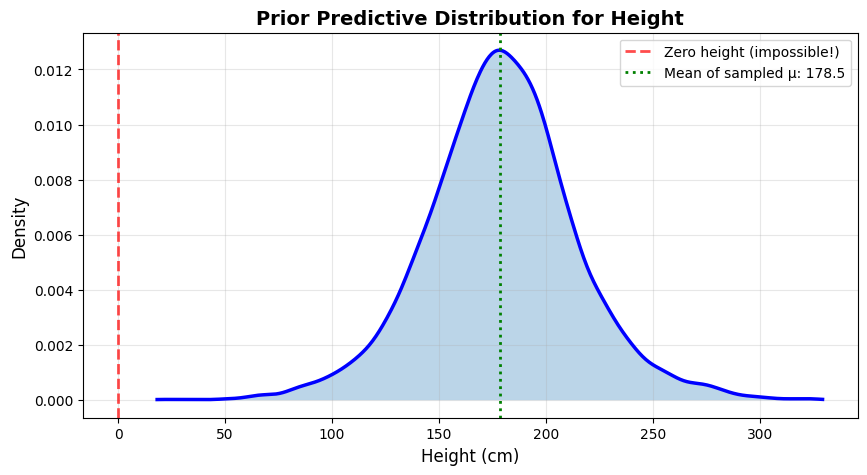

PRIOR PREDICTIVE CHECK - Do our priors make sense?

Predicted height range: [18.3, 329.1] cm
Mean predicted height: 179.0 cm
SD of predicted heights: 35.4 cm

5th-95th percentile: [121.6, 237.5] cm

Negative heights: 0 / 10000 (0.00%)
Taller than 272cm: 108 / 10000 (1.08%)

⚠️  WARNING: Priors produce implausible predictions!


In [40]:
# ============================================
# PRIOR PREDICTIVE SIMULATION
# ============================================
# NEW CONCEPT! This is the key technique introduced in Chapter 4
#
# GOAL: Simulate data our model would generate BEFORE seeing real data
# WHY: To check if our priors make sense and produce reasonable predictions
#
# THE PROCESS (run this 10,000 times):
#   1. Sample μ from our prior: Normal(178, 20)
#   2. Sample σ from our prior: Uniform(0, 50)
#   3. Sample height h from: Normal(μ, σ)
#   4. Store the height
#
# RESULT: A distribution of heights our model expects to see
# If this distribution includes impossible values (e.g., negative heights,
# 10-meter giants), then our priors are BAD!

# Set random seed for reproducibility
rng = np.random.default_rng(100)  # Modern numpy random number generator
n = 10_000  # Number of simulations

# Step 1 & 2: Sample parameters from priors
# Each simulation gets its own (μ, σ) pair!
sample_mu = rng.normal(loc=mu_mean, scale=mu_sd, size=n)
# sample_mu[0] might be 165, sample_mu[1] might be 182, etc.

sample_sigma = rng.uniform(low=sigma_low, high=sigma_high, size=n)
# sample_sigma[0] might be 12, sample_sigma[1] might be 35, etc.

# Step 3: Sample heights using the sampled parameters
# CRITICAL: Each height uses its corresponding (μ, σ) pair!
# prior_h[i] ~ Normal(sample_mu[i], sample_sigma[i])
# This is called "vectorized" sampling - numpy does this efficiently
prior_h = rng.normal(loc=sample_mu, scale=sample_sigma, size=n)

# ============================================
# VISUALIZE THE PRIOR PREDICTIVE DISTRIBUTION
# ============================================

# Estimate density using Kernel Density Estimation (KDE)
# KDE is like a smooth histogram - it estimates the continuous density from samples
# NEW CONCEPT: KDE (Kernel Density Estimation)
# - Takes discrete samples and creates a smooth curve
# - Imagine putting a small bell curve at each data point and adding them up
# - Result: smooth density curve that approximates the true distribution
kde = gaussian_kde(prior_h)

# Create dense grid for smooth plotting
x_h = np.linspace(prior_h.min(), prior_h.max(), 600)

# Plot the prior predictive distribution
plt.figure(figsize=(10, 5))
plt.plot(x_h, kde(x_h), 'b-', linewidth=2.5)
plt.fill_between(x_h, kde(x_h), alpha=0.3)
plt.axvline(0, color='red', linestyle='--', linewidth=2, 
            label='Zero height (impossible!)', alpha=0.7)
plt.axvline(sample_mu.mean(), color='green', linestyle=':', linewidth=2,
            label=f'Mean of sampled μ: {sample_mu.mean():.1f}')
plt.title("Prior Predictive Distribution for Height", fontsize=14, fontweight='bold')
plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# ANALYZE THE RESULTS
# ============================================

print("="*70)
print("PRIOR PREDICTIVE CHECK - Do our priors make sense?")
print("="*70)
print(f"\nPredicted height range: [{prior_h.min():.1f}, {prior_h.max():.1f}] cm")
print(f"Mean predicted height: {prior_h.mean():.1f} cm")
print(f"SD of predicted heights: {prior_h.std():.1f} cm")
print(f"\n5th-95th percentile: [{np.percentile(prior_h, 5):.1f}, {np.percentile(prior_h, 95):.1f}] cm")

# Check for impossible values
n_negative = (prior_h < 0).sum()
n_giants = (prior_h > 272).sum()  # World record ~272cm

print(f"\nNegative heights: {n_negative} / {n} ({100*n_negative/n:.2f}%)")
print(f"Taller than 272cm: {n_giants} / {n} ({100*n_giants/n:.2f}%)")

if n_negative > 0 or n_giants > n * 0.01:  # More than 1% giants
    print("\n⚠️  WARNING: Priors produce implausible predictions!")
else:
    print("\n✓ Priors look reasonable! Most predictions are plausible.")
print("="*70)

# KEY TAKEAWAY:
# We've validated our priors BEFORE seeing any data!
# If the prior predictive distribution had been crazy, we'd know to revise our priors

### Comparing Good vs Bad Priors

Let's see what happens with a **too vague** prior for μ:

**Good prior**: μ ~ N(178, 20)  
**Bad prior**: μ ~ N(178, 100) ← 5× larger SD!

With SD=100:
- 95% of μ values between -22cm and 378cm
- Allows negative heights and impossibly tall humans
- Results in very wide, implausible height predictions

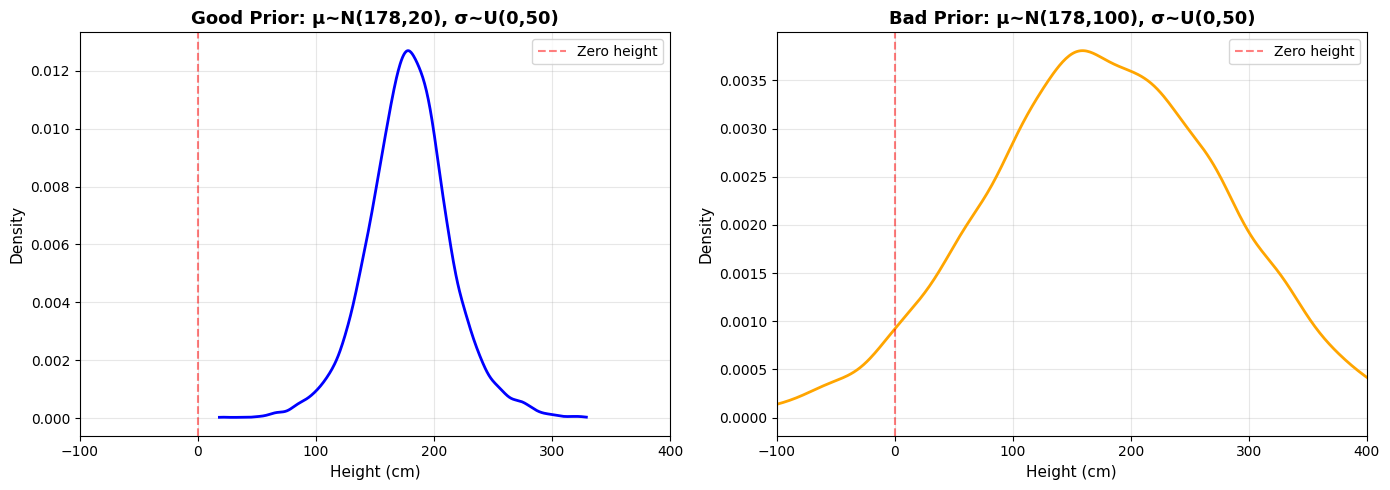

=== Prior Predictive Summary ===

Good Prior (μ~N(178,20)):
  Height range: [18.3, 329.1] cm
  Mean: 179.0 cm
  5th-95th percentile: [121.6, 237.5] cm
  Negative heights: 0 / 10000 (0.00%)

Bad Prior (μ~N(178,100)):
  Height range: [-238.5, 576.3] cm
  Mean: 178.2 cm
  5th-95th percentile: [5.0, 348.7] cm
  Negative heights: 449 / 10000 (4.49%)

✓ The good prior keeps heights in a reasonable range!
✗ The bad prior allows impossible values (negative, extremely tall)


In [41]:
# Simulate with bad prior (too vague)
mu_sd_bad = 100

sample_mu_bad = rng.normal(loc=mu_mean, scale=mu_sd_bad, size=n)
sample_sigma_bad = rng.uniform(low=sigma_low, high=sigma_high, size=n)
prior_h_bad = rng.normal(loc=sample_mu_bad, scale=sample_sigma_bad, size=n)

# Compute KDEs
kde_good = gaussian_kde(prior_h)
kde_bad = gaussian_kde(prior_h_bad)

x_h_good = np.linspace(prior_h.min(), prior_h.max(), 600)
x_h_bad = np.linspace(prior_h_bad.min(), prior_h_bad.max(), 600)

# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Good prior
ax1.plot(x_h_good, kde_good(x_h_good), 'b-', linewidth=2)
ax1.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero height')
ax1.set_title("Good Prior: μ~N(178,20), σ~U(0,50)", fontsize=13, fontweight='bold')
ax1.set_xlabel("Height (cm)", fontsize=11)
ax1.set_ylabel("Density", fontsize=11)
ax1.set_xlim(-100, 400)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bad prior
ax2.plot(x_h_bad, kde_bad(x_h_bad), 'orange', linewidth=2)
ax2.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero height')
ax2.set_title("Bad Prior: μ~N(178,100), σ~U(0,50)", fontsize=13, fontweight='bold')
ax2.set_xlabel("Height (cm)", fontsize=11)
ax2.set_ylabel("Density", fontsize=11)
ax2.set_xlim(-100, 400)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Prior Predictive Summary ===")
print(f"\nGood Prior (μ~N(178,20)):")
print(f"  Height range: [{prior_h.min():.1f}, {prior_h.max():.1f}] cm")
print(f"  Mean: {prior_h.mean():.1f} cm")
print(f"  5th-95th percentile: [{np.percentile(prior_h, 5):.1f}, {np.percentile(prior_h, 95):.1f}] cm")
print(f"  Negative heights: {(prior_h < 0).sum()} / {n} ({100*(prior_h < 0).mean():.2f}%)")

print(f"\nBad Prior (μ~N(178,100)):")
print(f"  Height range: [{prior_h_bad.min():.1f}, {prior_h_bad.max():.1f}] cm")
print(f"  Mean: {prior_h_bad.mean():.1f} cm")
print(f"  5th-95th percentile: [{np.percentile(prior_h_bad, 5):.1f}, {np.percentile(prior_h_bad, 95):.1f}] cm")
print(f"  Negative heights: {(prior_h_bad < 0).sum()} / {n} ({100*(prior_h_bad < 0).mean():.2f}%)")

print("\n✓ The good prior keeps heights in a reasonable range!")
print("✗ The bad prior allows impossible values (negative, extremely tall)")

## Summary: What We've Learned

### Key Takeaways

1. **Gaussian models** are useful for continuous outcomes like height
2. **Prior predictive simulation** helps validate priors before seeing data
3. **Good priors** balance:
   - Domain knowledge (178cm is reasonable for average height)
   - Uncertainty (SD=20 allows variation)
   - Constraints (no negative heights, no giants)

### Next Steps

In the next sections, we'll:
1. **Compute the posterior** using grid approximation
2. **Sample from the posterior** to get distributions for μ and σ
3. **Make predictions** using the posterior predictive distribution
4. **Check model fit** against actual data

### Workflow Review

```
Choose Model → Choose Priors → Prior Predictive → Compute Posterior → Posterior Predictive
     ↓              ↓                ↓                    ↓                    ↓
  h~N(μ,σ)     μ~N(178,20)     Simulate heights    Use data to     Check model fit
              σ~U(0,50)        (no data yet!)      update beliefs  (with data)
```

In [ ]:
# ============================================
# 2D GRID APPROXIMATION FOR POSTERIOR
# ============================================
# This is more complex than Chapter 3 because we have TWO parameters!

import numpy as np
from scipy.stats import norm, uniform

# ----- STEP 1: Prepare the data -----
y = adult_height  # Rename for clarity (y = observed heights)
print(f"Number of observations: {len(y)}")
print(f"Data range: [{y.min():.1f}, {y.max():.1f}] cm")

# ----- STEP 2: Define grids for parameters -----
# We need to guess reasonable ranges based on our prior knowledge and EDA

# For μ: We saw in EDA that adult mean ≈ 154cm
# Let's search in a range around that
mu_list = np.linspace(150, 160, 100)  # 100 evenly-spaced values

# For σ: We saw SD ≈ 7.7cm in EDA
# Let's search in a range around that
sigma_list = np.linspace(7, 9, 100)   # 100 evenly-spaced values

print(f"\nGrid dimensions:")
print(f"  μ range: [{mu_list[0]:.1f}, {mu_list[-1]:.1f}] with {len(mu_list)} points")
print(f"  σ range: [{sigma_list[0]:.1f}, {sigma_list[-1]:.1f}] with {len(sigma_list)} points")
print(f"  Total grid points: {len(mu_list) * len(sigma_list):,}")

# ----- STEP 3: Create 2D meshgrid -----
# NEW CONCEPT: np.meshgrid creates all (μ, σ) combinations
# Think of it like expand.grid() in R
#
# Result: MU and SIGMA are both (100, 100) matrices where:
#   MU[i,j] = j-th value of mu_list (varies across columns)
#   SIGMA[i,j] = i-th value of sigma_list (varies across rows)

MU, SIGMA = np.meshgrid(mu_list, sigma_list, indexing="xy")

# Example: MU[0, :] = [150.0, 150.1, 150.2, ..., 160.0]
#          SIGMA[:, 0] = [7.0, 7.02, 7.04, ..., 9.0]

# ----- STEP 4: Compute log-likelihood for each (μ, σ) pair -----
# NEW CONCEPT: Broadcasting in 3D!
#
# For each (μ, σ) pair, compute:
#   log-likelihood = sum of log P(y_i | μ, σ) over all observations
#
# We use norm.logpdf for numerical stability (avoids underflow)
# Shape gymnastics:
#   y:     shape (352,)           → reshape to (1, 1, 352)
#   MU:    shape (100, 100)       → broadcast to (100, 100, 352)
#   SIGMA: shape (100, 100)       → broadcast to (100, 100, 352)
#   Result after sum: shape (100, 100)

# Add dimensions to y for broadcasting
y_3d = y[None, None, :]  # Shape: (1, 1, 352)
MU_3d = MU[:, :, None]   # Shape: (100, 100, 1) → broadcasts to (100, 100, 352)
SIGMA_3d = SIGMA[:, :, None]  # Shape: (100, 100, 1) → broadcasts to (100, 100, 352)

# Compute log P(y_i | μ, σ) for all y_i and all (μ, σ)
# Result shape: (100, 100, 352)
log_lik_per_obs = norm.logpdf(y_3d, loc=MU_3d, scale=SIGMA_3d)

# Sum over observations (axis=2) → shape (100, 100)
loglik = np.sum(log_lik_per_obs, axis=2)

print(f"\nLog-likelihood computed:")
print(f"  Shape: {loglik.shape}")
print(f"  Range: [{loglik.min():.1f}, {loglik.max():.1f}]")

# ----- STEP 5: Add log-priors -----
# Prior for μ: Normal(178, 20)
logprior_mu = norm.logpdf(MU, loc=178, scale=20)

# Prior for σ: Uniform(0, 50)
logprior_sigma = uniform.logpdf(SIGMA, loc=0, scale=50)

# Combine (still on log scale)
# log P(μ, σ | data) ∝ log P(data | μ, σ) + log P(μ) + log P(σ)
logposterior_unnorm = loglik + logprior_mu + logprior_sigma

# ----- STEP 6: Exponentiate (careful with numerical stability!) -----
# Subtract maximum to avoid overflow when exponentiating
# This doesn't change the shape, just prevents exp() from exploding
logposterior_unnorm = logposterior_unnorm - np.max(logposterior_unnorm)

# Now safe to exponentiate
posterior_unnorm = np.exp(logposterior_unnorm)

# ----- STEP 7: Normalize to get proper probability distribution -----
# Make it sum to 1 so it's a discrete probability distribution
posterior = posterior_unnorm / posterior_unnorm.sum()

print(f"\nPosterior computed:")
print(f"  Shape: {posterior.shape}")
print(f"  Sum: {posterior.sum():.6f} (should be 1.0)")
print(f"  Max probability: {posterior.max():.6f}")

print("\n✓ Posterior computation complete!")
print("="*70)

## Step 5: Compute the Posterior using Grid Approximation

### NEW CHALLENGE: 2D Grid Approximation!

Previously (Chapter 3), we only had ONE parameter (p for globe tossing).  
Now we have **TWO parameters**: μ AND σ!

**The approach:**
1. Create a 2D grid of (μ, σ) combinations
2. Compute posterior probability at each grid point
3. Normalize so probabilities sum to 1

**The math:**
```
Posterior(μ, σ | data) ∝ Likelihood(data | μ, σ) × Prior(μ) × Prior(σ)
```

For each (μ, σ) pair on our grid:
- **Likelihood**: How well does this (μ, σ) explain the observed heights?
- **Prior**: How plausible is this (μ, σ) before seeing data?

### Why Grid Approximation?

- **Exact**: No sampling error (unlike MCMC)
- **Simple**: Easy to understand and implement
- **Limited**: Only works for 1-3 parameters (curse of dimensionality!)

For this problem: 100×100 = **10,000 grid points** to evaluate

In [ ]:
# Visualize posterior as a heatmap
plt.figure(figsize=(9, 6))

# imshow displays a 2D array as an image
# Each pixel's color represents the posterior probability at that (μ, σ)
plt.imshow(
    posterior,
    origin="lower",  # Put (0,0) at bottom-left (not top-left)
    aspect="auto",   # Don't force square pixels
    extent=[mu_list.min(), mu_list.max(), sigma_list.min(), sigma_list.max()],
    cmap='viridis'   # Color scheme (yellow=high, purple=low)
)

plt.xlabel("μ (mean height, cm)", fontsize=12)
plt.ylabel("σ (std dev, cm)", fontsize=12)
plt.title("2D Posterior Distribution: P(μ, σ | data)", fontsize=14, fontweight='bold')
plt.colorbar(label="Posterior probability")
plt.grid(False)  # Turn off grid for heatmap
plt.show()

# INTERPRETATION:
# - Bright region = high posterior probability (most plausible values)
# - Dark region = low posterior probability (implausible given data)
# - The bright spot is around μ≈154, σ≈7.7 (close to sample statistics!)

### Visualize the 2D Posterior

The posterior is a **2D probability distribution** over (μ, σ).  
We can visualize it as:
1. **Heatmap**: Color intensity shows probability
2. **Contour plot**: Lines connect points of equal probability

In [ ]:
# Find the location of maximum posterior probability
# np.argmax finds the INDEX of the maximum value in the flattened array
# np.unravel_index converts flat index back to (row, col) coordinates

idx = np.unravel_index(np.argmax(posterior), posterior.shape)
# idx[0] = row index (corresponds to sigma_list)
# idx[1] = column index (corresponds to mu_list)

sigma_map = sigma_list[idx[0]]
mu_map = mu_list[idx[1]]

print("="*60)
print("MAP (Maximum A Posteriori) Estimates:")
print("="*60)
print(f"MAP μ: {mu_map:.2f} cm")
print(f"MAP σ: {sigma_map:.2f} cm")
print(f"\nCompare to sample statistics:")
print(f"Sample mean: {adult_height.mean():.2f} cm")
print(f"Sample SD: {adult_height.std():.2f} cm")
print(f"\nDifference:")
print(f"  μ diff: {abs(mu_map - adult_height.mean()):.3f} cm")
print(f"  σ diff: {abs(sigma_map - adult_height.std()):.3f} cm")
print("="*60)

# Visualize MAP on contour plot
plt.figure(figsize=(9, 6))

# Contour plot shows lines of equal probability
plt.contour(mu_list, sigma_list, posterior, levels=20, cmap='viridis')

# Mark the MAP point with a red X
plt.scatter([mu_map], [sigma_map], marker="x", s=200, c='red', 
            linewidths=3, label=f'MAP: μ={mu_map:.1f}, σ={sigma_map:.1f}', zorder=5)

plt.xlabel("μ (mean height, cm)", fontsize=12)
plt.ylabel("σ (std dev, cm)", fontsize=12)
plt.title("Posterior Contours with MAP Estimate", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# KEY INSIGHT: MAP estimates are very close to sample statistics!
# This happens when:
# 1. We have lots of data (352 adults)
# 2. Prior is weak (doesn't dominate the data)
# With less data, MAP would be pulled toward the prior

### Find the MAP (Maximum A Posteriori) Estimate

**MAP** = The (μ, σ) pair with highest posterior probability  
This is the "most plausible" parameter values given the data.

In [ ]:
# ============================================
# MARGINALIZATION: From Joint to Marginal Distributions
# ============================================

# Our posterior has shape (100, 100) representing P(μ, σ | data)
# Rows correspond to different σ values
# Columns correspond to different μ values

# Marginal of μ: P(μ | data) regardless of σ
# HOW: Sum over all rows (all σ values) for each μ
# Think: "For this μ, sum probability across ALL possible σ"
p_mu = posterior.sum(axis=0)  # Sum over axis 0 (rows/sigma) → shape (100,)
p_mu = p_mu / p_mu.sum()      # Renormalize to ensure it sums to 1

# Marginal of σ: P(σ | data) regardless of μ
# HOW: Sum over all columns (all μ values) for each σ
# Think: "For this σ, sum probability across ALL possible μ"
p_sigma = posterior.sum(axis=1)  # Sum over axis 1 (cols/mu) → shape (100,)
p_sigma = p_sigma / p_sigma.sum()  # Renormalize to ensure it sums to 1

print("="*60)
print("MARGINAL DISTRIBUTIONS COMPUTED")
print("="*60)
print(f"P(μ | data):")
print(f"  Shape: {p_mu.shape}")
print(f"  Sums to: {p_mu.sum():.6f}")
print(f"\nP(σ | data):")
print(f"  Shape: {p_sigma.shape}")
print(f"  Sums to: {p_sigma.sum():.6f}")
print("="*60)

# INTERPRETATION:
# p_mu tells us: "What are plausible values of μ, averaging over uncertainty in σ?"
# p_sigma tells us: "What are plausible values of σ, averaging over uncertainty in μ?"

### Compute Marginal Distributions

**KEY CONCEPT: Marginalization**

We have the **joint posterior** P(μ, σ | data), but sometimes we want:
- P(μ | data) **regardless** of what σ is
- P(σ | data) **regardless** of what μ is

These are called **marginal distributions**.

**How to marginalize:**
- To get P(μ | data): Sum posterior over all possible σ values
- To get P(σ | data): Sum posterior over all possible μ values

**Why this works:**
```
P(μ | data) = ∫ P(μ, σ | data) dσ
```
In discrete grid approximation, integral becomes sum!

In [ ]:
# Plot the marginal distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Marginal of μ
ax1.plot(mu_list, p_mu, 'b-', linewidth=2.5)
ax1.fill_between(mu_list, p_mu, alpha=0.3)
ax1.axvline(mu_map, color='red', linestyle='--', linewidth=2, 
            label=f'MAP = {mu_map:.2f}')
ax1.set_xlabel("μ (population mean, cm)", fontsize=12)
ax1.set_ylabel("P(μ | data)", fontsize=12)
ax1.set_title("Marginal Posterior of μ", fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Marginal of σ
ax2.plot(sigma_list, p_sigma, 'g-', linewidth=2.5)
ax2.fill_between(sigma_list, p_sigma, alpha=0.3)
ax2.axvline(sigma_map, color='red', linestyle='--', linewidth=2,
            label=f'MAP = {sigma_map:.2f}')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=12)
ax2.set_ylabel("P(σ | data)", fontsize=12)
ax2.set_title("Marginal Posterior of σ", fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# KEY OBSERVATIONS:
# 1. Both marginals are roughly bell-shaped
# 2. μ has narrower distribution (more certain) than σ
# 3. MAP estimates are at the peaks (by definition!)
#
# WHY is μ more certain than σ?
# - Mean is easier to estimate than variance from data
# - Variance has more inherent uncertainty

print("\nMarginal statistics:")
print(f"P(μ | data): mean={np.sum(mu_list * p_mu):.2f}, std={np.sqrt(np.sum((mu_list - np.sum(mu_list * p_mu))**2 * p_mu)):.2f}")
print(f"P(σ | data): mean={np.sum(sigma_list * p_sigma):.2f}, std={np.sqrt(np.sum((sigma_list - np.sum(sigma_list * p_sigma))**2 * p_sigma)):.2f}")

In [ ]:
# ============================================
# SAMPLING FROM THE 2D POSTERIOR
# ============================================
# This is TRICKY because we have a 2D grid, not a simple list!

rng = np.random.default_rng(123)  # Set seed for reproducibility
n_samples = 10_000

# STEP 1: Flatten the 2D posterior into 1D
# posterior shape: (100, 100) → flat_post shape: (10000,)
# This treats each grid cell as a single outcome
flat_post = posterior.ravel()  # or .flatten()

# Ensure it sums to 1 (should already, but be safe)
flat_post = flat_post / flat_post.sum()

# STEP 2: Sample grid cell INDICES proportional to their probabilities
# np.random.choice samples integers from 0 to flat_post.size-1
# with probabilities given by flat_post
#
# Example: If cell 5432 has high probability, it will be sampled often
draws = rng.choice(flat_post.size, size=n_samples, replace=True, p=flat_post)
# draws is array of integers: [5432, 234, 5431, 6789, ...]

# STEP 3: Convert flat indices back to 2D (row, col) indices
# np.unravel_index is the inverse of .ravel()
#
# If draws[i] = 5432, this tells us:
# - Which row (σ index)?
# - Which column (μ index)?
rows, cols = np.unravel_index(draws, posterior.shape)

# STEP 4: Convert indices to actual parameter values
# rows[i] tells us which sigma_list entry
# cols[i] tells us which mu_list entry
mu_samples = mu_list[cols]
sigma_samples = sigma_list[rows]

print("="*70)
print("POSTERIOR SAMPLES")
print("="*70)
print(f"Number of samples: {n_samples:,}")
print(f"\nμ samples:")
print(f"  Mean: {mu_samples.mean():.3f} cm")
print(f"  SD: {mu_samples.std():.3f} cm")
print(f"  5th-95th percentile: [{np.percentile(mu_samples, 5):.2f}, {np.percentile(mu_samples, 95):.2f}] cm")

print(f"\nσ samples:")
print(f"  Mean: {sigma_samples.mean():.3f} cm")
print(f"  SD: {sigma_samples.std():.3f} cm")
print(f"  5th-95th percentile: [{np.percentile(sigma_samples, 5):.2f}, {np.percentile(sigma_samples, 95):.2f}] cm")

# Compare to MAP
print(f"\nMAP estimates for comparison:")
print(f"  μ_MAP = {mu_map:.3f} cm")
print(f"  σ_MAP = {sigma_map:.3f} cm")

print("\n✓ Now we can use these samples for any downstream analysis!")
print("="*70)

# THESE SAMPLES CAPTURE THE FULL UNCERTAINTY IN BOTH PARAMETERS!
# This is different from just using point estimates (like MAP)

### Sample from the Posterior

**Why sample when we have the exact posterior?**

Grid approximation gives us the FULL posterior, but:
- Easier to work with **samples** for downstream tasks
- Can compute any statistic (quantiles, intervals, predictions)
- Matches workflow for MCMC (Chapter 9)

**The challenge:** Sampling from a 2D discrete distribution

**The approach:**
1. Flatten the 2D posterior into a 1D array
2. Sample grid indices proportional to their probabilities
3. Convert indices back to (μ, σ) values